<a href="https://colab.research.google.com/github/lise1905/mini_project/blob/main/cloth_recom_direct_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
#pip install flask-ngrok

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/mini_project

/content/drive/MyDrive/Colab Notebooks/mini_project


In [4]:
df = pd.read_excel('dataset_cloth_recom.xlsx')

In [5]:
print(df.head(10))

   fit  user_id bust size  item_id  weight  ...  category height  size    age product
0  fit   420272       34d  2260466  137lbs  ...    romper  5' 8"  14.0   28.0   1.jpg
1  fit   273551       34b   153475  132lbs  ...      gown  5' 6"  12.0   36.0   2.jpg
2  fit   360448       NaN  1063761     NaN  ...    sheath  5' 4"   4.0  116.0  15.jpg
3  fit   909926       34c   126335  135lbs  ...     dress  5' 5"   8.0   34.0   4.jpg
4  fit   151944       34b   616682  145lbs  ...      gown  5' 9"  12.0   27.0   5.jpg
5  fit   734848       32b   364092  138lbs  ...     dress  5' 8"   8.0   45.0   6.jpg
6  fit   336066       34c   568429  112lbs  ...     dress  5' 3"   4.0   27.0   7.jpg
7  fit    86661      34d+   130259  118lbs  ...     dress  5' 3"   8.0   65.0   8.jpg
8  fit   166228       36d  1729232     NaN  ...      gown  5' 6"  21.0   27.0   9.jpg
9  fit   126461       36c   132135  129lbs  ...      gown  5' 6"   7.0   20.0  10.jpg

[10 rows x 15 columns]


In [7]:
data=df.drop(['review_text','review_summary'],axis = 1)

In [8]:
data.dtypes

fit            object
user_id         int64
bust size      object
item_id         int64
weight         object
rating          int64
rented for     object
body type      object
category       object
height         object
size          float64
age           float64
product        object
dtype: object

In [9]:
print(data.head(10))

   fit  user_id bust size  item_id  weight  ...  category height  size    age product
0  fit   420272       34d  2260466  137lbs  ...    romper  5' 8"  14.0   28.0   1.jpg
1  fit   273551       34b   153475  132lbs  ...      gown  5' 6"  12.0   36.0   2.jpg
2  fit   360448       NaN  1063761     NaN  ...    sheath  5' 4"   4.0  116.0  15.jpg
3  fit   909926       34c   126335  135lbs  ...     dress  5' 5"   8.0   34.0   4.jpg
4  fit   151944       34b   616682  145lbs  ...      gown  5' 9"  12.0   27.0   5.jpg
5  fit   734848       32b   364092  138lbs  ...     dress  5' 8"   8.0   45.0   6.jpg
6  fit   336066       34c   568429  112lbs  ...     dress  5' 3"   4.0   27.0   7.jpg
7  fit    86661      34d+   130259  118lbs  ...     dress  5' 3"   8.0   65.0   8.jpg
8  fit   166228       36d  1729232     NaN  ...      gown  5' 6"  21.0   27.0   9.jpg
9  fit   126461       36c   132135  129lbs  ...      gown  5' 6"   7.0   20.0  10.jpg

[10 rows x 13 columns]


In [10]:
pip install surprise

     |████████████████████████████████| 11.8 MB 5.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630182 sha256=b86b7cd19fc39dd22ffa6683de9808361007e4a84e402e2b92e0f0e4e168a338
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [11]:
from surprise import Dataset
from surprise import Reader
import os, io
from surprise import SVD
from surprise import accuracy

In [12]:
train, test = train_test_split(data, test_size=0.2)

In [13]:
def preprocessAge(data):
  bins = pd.IntervalIndex.from_tuples([(5, 15), (15, 30), (30, 50),(50,65),(65,100)])
  x = pd.cut(data['age'].to_list(), bins)
  x.categories = ['1','2','3','4','5']
  data['age_bins']  = x
  age_Preprocessed_data = data[~data['age_bins'].isnull()]
  # print ('{0} rows got dropped after age preprocessing'.format(str(data.shape[0] - age_Preprocessed_data.shape[0])))
  return age_Preprocessed_data

In [14]:
def preprocessBustsize(age_Preprocessed_data):
  data_bust_size_not_null = age_Preprocessed_data[~age_Preprocessed_data['bust size'].isnull()]
  data_bust_size_not_null['bust size'] = data_bust_size_not_null['bust size'].apply(lambda x : (int(x[:2]), x[2:]))
  data_bust_size_not_null.shape
  data_bust_size_not_null[['bust Size1', 'bust']] = pd.DataFrame(data_bust_size_not_null['bust size'].tolist(), index=data_bust_size_not_null.index)
  bustDict = {'a': 1, 'aa': 1, 'b': 2, 'c': 3, 'd': 4, 
            'd+': 5, 'dd': 5, 'ddd/e': 6,
           'f':7 , 'g': 8, 'h': 9, 'i': 10, 'j': 11}
  data_bust_size_not_null['bust1'] = data_bust_size_not_null['bust'].map(bustDict)
  # Calculating model of bust size based on age grp.
  def funct(df):
    return df.mode()
  x = data_bust_size_not_null[['age_bins','bust Size1','bust1']].groupby('age_bins').apply(funct)
  x.reset_index(inplace= True, drop = True)
  data_bust_size_null = age_Preprocessed_data[age_Preprocessed_data['bust size'].isnull()]
  data_bust_size_null = pd.merge(data_bust_size_null, x, how ='left', left_on = 'age_bins', right_on = 'age_bins')
  data_bust_size_cleansed = data_bust_size_not_null.append(data_bust_size_null)
  return data_bust_size_cleansed

In [15]:
def preprocessHeight(data_bust_size_cleansed):
  data_bust_size_cleansed['heightCM'] = data_bust_size_cleansed['height'].apply(lambda x : (int(x.split("\'")[0]) * 30.48) + (int(x.split("\'")[1][:-1]) * 2.54) 
                                                        if type(x) == str else x)
  data_bust_size_cleansed['heightCM'].fillna((data_bust_size_cleansed['heightCM'].mean()), inplace=True)
  return data_bust_size_cleansed

In [16]:
def preprocessWeight(data_bust_size_cleansed):
  data_bust_size_cleansed['weightLbs'] = data_bust_size_cleansed['weight'].apply(lambda x : int(x[:-3])                                                        if type(x) == str else x)
  data_bust_size_cleansed['weightLbs'].fillna((data_bust_size_cleansed['weightLbs'].mean()), inplace=True)
  return data_bust_size_cleansed

In [17]:
def preprocessRentedFor(data_bust_size_cleansed):
  data_bust_size_cleansed['rented for'].fillna('other', inplace=True)
  return data_bust_size_cleansed

In [18]:
def preprocessBodytype(data_bust_size_cleansed):
  # Calculating model of body type based on Bust Size.
  data_body_type_not_null = data_bust_size_cleansed[~data_bust_size_cleansed['body type'].isnull()]
  def func(df):
    return df.mode()
  x = data_body_type_not_null[['bust Size1','body type']].groupby('bust Size1').apply(func)
  x.reset_index(inplace= True, drop = True)
  # print(x)
  data_body_type_null = data_bust_size_cleansed[data_bust_size_cleansed['body type'].isnull()]
  data_body_type_null = pd.merge(data_body_type_null, x, how ='left', left_on = 'bust Size1', right_on = 'bust Size1')
  # print(data_body_type_null)
  data_body_type_cleansed = data_body_type_not_null.append(data_body_type_null,sort=True)
  # print(data_body_type_cleansed)
  data_body_type_cleansed['body type'].fillna(data_body_type_cleansed['body type_y'], inplace=True)
  del data_body_type_cleansed['body type_x']
  del data_body_type_cleansed['body type_y']
  return data_body_type_cleansed

In [19]:
def createFinalDataframe(cleansedData):
  final_df=cleansedData.copy()
  final_df=final_df.drop(['rented for','rating','category','age_bins','bust','bust size','fit','height','item_id','user_id','weight'],axis=1)
  cleanup_nums = {"body type":     {"hourglass": 1, "straight & narrow": 2, "pear": 3,"athletic": 4, "full bust": 5,"petite": 6, "apple": 7}}
  final_df.replace(cleanup_nums, inplace=True)
  return final_df

In [20]:
def createFinalTestDataframe(cleansedData):
  final_df=cleansedData.copy()
  final_df=final_df.drop(['rating','category','age_bins','bust','bust size','fit','height','item_id','weight'],axis=1)
  cleanup_nums = {"body type":     {"hourglass": 1, "straight & narrow": 2, "pear": 3,"athletic": 4, "full bust": 5,"petite": 6, "apple": 7}}
  final_df.replace(cleanup_nums, inplace=True)
  return final_df

In [21]:
age_Preprocessed_data=preprocessAge(train)
data_bust_size_cleansed=preprocessBustsize(age_Preprocessed_data)
data_bust_size_cleansed=preprocessHeight(data_bust_size_cleansed)
data_bust_size_cleansed=preprocessWeight(data_bust_size_cleansed)
data_bust_size_cleansed=preprocessRentedFor(data_bust_size_cleansed)
cleansedData=preprocessBodytype(data_bust_size_cleansed)
final_df=createFinalDataframe(cleansedData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [22]:
feature_names = ['age', 'bust Size1','bust1','size','heightCM','weightLbs']
X = final_df[feature_names]
y = final_df['body type']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
print(X)

     age  bust Size1  bust1  size  heightCM   weightLbs
86  31.0        34.0      2  17.0    167.64  130.000000
39  37.0        34.0      3  16.0    175.26  160.000000
23  36.0        36.0      3  17.0    170.18  155.000000
75  44.0        34.0      2  12.0    162.56  128.000000
64  37.0        36.0      4  16.0    162.56  132.000000
..   ...         ...    ...   ...       ...         ...
1   33.0        36.0      3  12.0    165.10  145.000000
2   27.0        32.0      3   8.0    160.02  128.000000
3   29.0        36.0      5  28.0    160.02  140.819444
4   32.0        34.0      4   1.0    160.02  115.000000
5   35.0        34.0      4  24.0    165.10  165.000000

[81 rows x 6 columns]


In [24]:
print(y)

86    1
39    3
23    4
75    4
64    5
     ..
1     4
2     1
3     4
4     4
5     4
Name: body type, Length: 81, dtype: int64


In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy of Random forest classifier on training set: {:.2f}'
    .format(model.score(X_train, y_train)))
print('Accuracy of Random forest classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))


              precision    recall  f1-score   support

           1       0.67      0.57      0.62         7
           2       0.50      0.50      0.50         2
           3       0.33      0.33      0.33         3
           4       0.17      0.20      0.18         5
           5       0.00      0.00      0.00         2
           6       0.50      0.50      0.50         2

    accuracy                           0.38        21
   macro avg       0.36      0.35      0.36        21
weighted avg       0.40      0.38      0.39        21

Accuracy of Random forest classifier on training set: 1.00
Accuracy of Random forest classifier on test set: 0.38


In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred1 = knn.predict(X_test)
#print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



              precision    recall  f1-score   support

           1       0.45      0.71      0.56         7
           2       0.00      0.00      0.00         2
           3       0.33      0.33      0.33         3
           4       0.67      0.40      0.50         5
           5       0.00      0.00      0.00         2
           6       0.25      0.50      0.33         2

    accuracy                           0.43        21
   macro avg       0.28      0.32      0.29        21
weighted avg       0.38      0.43      0.38        21

Accuracy of K-NN classifier on training set: 0.38
Accuracy of K-NN classifier on test set: 0.43


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
age_Preprocessed_testdata=preprocessAge(test)
testdata_bust_size_cleansed=preprocessBustsize(age_Preprocessed_testdata)
testdata_bust_size_cleansed=preprocessHeight(testdata_bust_size_cleansed)
testdata_bust_size_cleansed=preprocessWeight(testdata_bust_size_cleansed)
testdata_bust_size_cleansed=preprocessRentedFor(testdata_bust_size_cleansed)
cleansedTestData=preprocessBodytype(testdata_bust_size_cleansed)
final_test_df=createFinalTestDataframe(cleansedTestData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [28]:
feature_names = ['age', 'bust Size1','bust1','size','heightCM','weightLbs','rented for','user_id']
testdata = final_test_df[feature_names]

In [29]:
for col in testdata.columns:
    print(col)

age
bust Size1
bust1
size
heightCM
weightLbs
rented for
user_id


In [30]:
print(testdata)

      age  bust Size1  bust1  size  heightCM  weightLbs     rented for  user_id
5    45.0          32    2.0   8.0    172.72   138.0000           date   734848
30   39.0          36    4.0  14.0    154.94   134.1875          other   648840
22   27.0          32    1.0   1.0    152.40   105.0000          party   697930
13   53.0          34    3.0  12.0    165.10   140.0000           work   946060
70   36.0          32    3.0  16.0    180.34   140.0000       everyday   440239
90   70.0          36    2.0  14.0    165.10   135.0000       everyday   162244
51   32.0          34    2.0   4.0    162.56   112.0000          party   145159
79   31.0          34    2.0  12.0    167.64   134.1875          party   312823
68   29.0          36    2.0   8.0    152.40   134.1875        wedding   324412
36   26.0          34    5.0  12.0    167.64   145.0000  formal affair   199544
103  32.0          36    1.0   8.0    172.72   150.0000        wedding   329989
54   35.0          32    1.0   1.0    15

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
#%cd ..

In [32]:
print(final_df)

     age  body type  bust Size1  bust1  heightCM  product  size   weightLbs
86  31.0          1        34.0      2    167.64  555.jpg  17.0  130.000000
39  37.0          3        34.0      3    175.26  515.jpg  16.0  160.000000
23  36.0          4        36.0      3    170.18  101.jpg  17.0  155.000000
75  44.0          4        34.0      2    162.56   44.jpg  12.0  128.000000
64  37.0          5        36.0      4    162.56  419.jpg  16.0  132.000000
..   ...        ...         ...    ...       ...      ...   ...         ...
1   33.0          4        36.0      3    165.10  126.jpg  12.0  145.000000
2   27.0          1        32.0      3    160.02  191.jpg   8.0  128.000000
3   29.0          4        36.0      5    160.02  733.jpg  28.0  140.819444
4   32.0          4        34.0      4    160.02  149.jpg   1.0  115.000000
5   35.0          4        34.0      4    165.10  671.jpg  24.0  165.000000

[81 rows x 8 columns]


Enter age:46
Enter bust size:45
Enter cup size:5
Enter size:20
Enter height cm:159
Enter weight lbs:176
Enter occasion:other


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Predicted body type: ['full bust']
Recommended itemID: 136110
Recommended category: dress
Recommended product: 16.jpg
Occasion: other


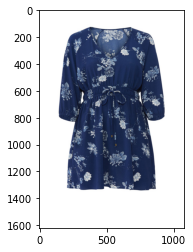

In [33]:
cf_df=[]
age = input("Enter age:")
bustSize1 = input("Enter bust size:")
bust1 = input("Enter cup size:")#bust size-band size
size = input("Enter size:")#dress size
heightCM = input("Enter height cm:")
weightLbs = input("Enter weight lbs:")
rented_for = input("Enter occasion:")
    
xnew=[[age,bustSize1,bust1,size,heightCM,weightLbs]]
bodytypenumber=model.predict(xnew)

bodytypearray=["NaN","hourglass", "straight & narrow", "pear","athletic", "full bust","petite", "apple"]
bodytype=np.asanyarray(bodytypearray)[bodytypenumber]
print("Predicted body type:",bodytype)
    
cluster_df=cleansedData.copy()
groupedbybodytype = cluster_df.groupby('body type')
for name,group in groupedbybodytype:
  if(bodytype==name):
    grouped_df=group.copy()
  rentedFor=rented_for

groupedbybodytype = grouped_df.groupby('rented for')
for name,group in groupedbybodytype:
  if(rentedFor==name):
    cf_df=group.copy()
cf_df=cf_df[['user_id','item_id','rating']].copy()
    
    
reader = Reader(rating_scale=(1,10))
traindata=Dataset.load_from_df(cf_df,reader)
trainingSet = traindata.build_full_trainset()
    
svdAlgo = SVD(n_factors=200,n_epochs=50)
svdAlgo.fit(trainingSet)
    
itemid=cf_df['item_id'].unique()
ratingOutput = pd.DataFrame(columns=['item_id', 'rating']) #Create a blank df with 2 columns at first and then append data
    
for i in range(len(itemid)):
  user=cf_df.iloc[i,0] #User_id
  item=cf_df.iloc[i,1] #Item_id
  output=svdAlgo.predict(user,item,r_ui=None,clip=True,verbose=False)
  ratingOutput = ratingOutput.append({'item_id': item, 'rating': output.est}, ignore_index=True)
        
ratingOutput=ratingOutput.sort_values('rating',ascending=False)
outputdf=ratingOutput.head(10).copy()
    #print("Top 10 recommended items with their predicted ratings:")
    #outputdf.head()
rawdf = pd.read_excel("dataset_cloth_recom.xlsx")
itemID=outputdf['item_id'].iloc[0]#.astype('int64')
print("Recommended itemID:",itemID)
finaldf = (rawdf[rawdf['item_id']==itemID].iloc[0])
print("Recommended category:",finaldf['category'])
finalpro = (rawdf[rawdf['item_id']==itemID].iloc[0])
print("Recommended product:",finaldf['product'])
print("Occasion:",finaldf['rented for'])
plt.imshow(mpimg.imread(finaldf['product']))
    
